In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from wordcloud import WordCloud
from collections import Counter

c:\Users\mario\Desktop\NLP\FinSent\env_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "../data/topic/topics_aggressive.csv"

In [3]:
df = pd.read_csv(dataset_path)

print(df.shape)
df.head(5)

(4821, 5)


,label,text,cleaned_text,topic,topic_name
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...,108,russia
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less NUM s...,0,sq
2,negative,The international electronic industry company ...,international electronic industry company elco...,40,elcoteq
3,positive,With the new production plant the company woul...,new production plant company would increase ca...,-1,Outlier
4,positive,According to the company 's updated strategy f...,according company updated strategy year NUM NU...,33,basware


In [4]:
topics = df["topic_name"].unique()
n_topics = len(topics)

print(f"{n_topics} topic totali:")
print(topics)

113 topic totali:
['russia' 'sq' 'elcoteq' 'Outlier' 'basware' 'aspo' 'pretax' 'sales' 'mn'
 'teliasonera' 'enso' 'mln' 'respectively' 'day' 'incap' 'dividend'
 'million' 'income' 'secure' 'beer' 'viking' 'fair' 'hel' 'eps' 'finnair'
 'decreased' 'nokia' 'biohit' 'value' 'kymmene' 'alma' 'our' 'meat'
 'cramo' 'stake' 'teleste' 'pct' 'option' 'shares' 'china' 'tj' 'register'
 'scheduled' 'tikkurila' 'driver' 'expects' 'cash' 'margin' 'ruukki'
 'sanoma' 'tonnes' 'yit' 'tekla' 'aldata' 'tecnomen' 'omx' 'finland'
 'kesko' 'kone' 'employs' 'oil' 'clothing' 'cargotec' 'offices' 'vaisala'
 'elisa' 'benefon' 'paper' 'data' 'stockmann' 'efore' 'pohjola' 'shimano'
 'investment' 'patent' 'tyres' 'capman' 'ramirent' 'contract'
 'installation' 'veneer' 'digia' 'panostaja' 'fortum' 'mobile' 'fiskars'
 'outokumpu' 'cencorp' 'pharmaceutical' 'ahlstrom' 'suominen'
 'recommendation' 'nordea' 'glass' 'comptel' 'loss' 'lay' 'savings'
 'sampo' 'lemminkainen' 'poyry' 'negotiations' 'rapala' 'ceo' 'oriola'
 

In [5]:
def custom_barplot(x_data, y_data, title, xlabel, ylabel, fig_size=(15,8)):    

    # Set dimensione e stile del grafico
    sns.set(style="whitegrid")  # stile seaborn
    warnings.filterwarnings("ignore", category=FutureWarning)
    plt.figure(figsize=fig_size)  # Altezza grande per visualizzare tutti i topic
    plot = sns.barplot(x=x_data, y=y_data, palette="viridis")
    
    plt.title(title, fontweight="bold", pad=15)
    plt.xlabel(xlabel, labelpad=10, fontweight="bold")
    plt.ylabel(ylabel, labelpad=10, fontweight="bold")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

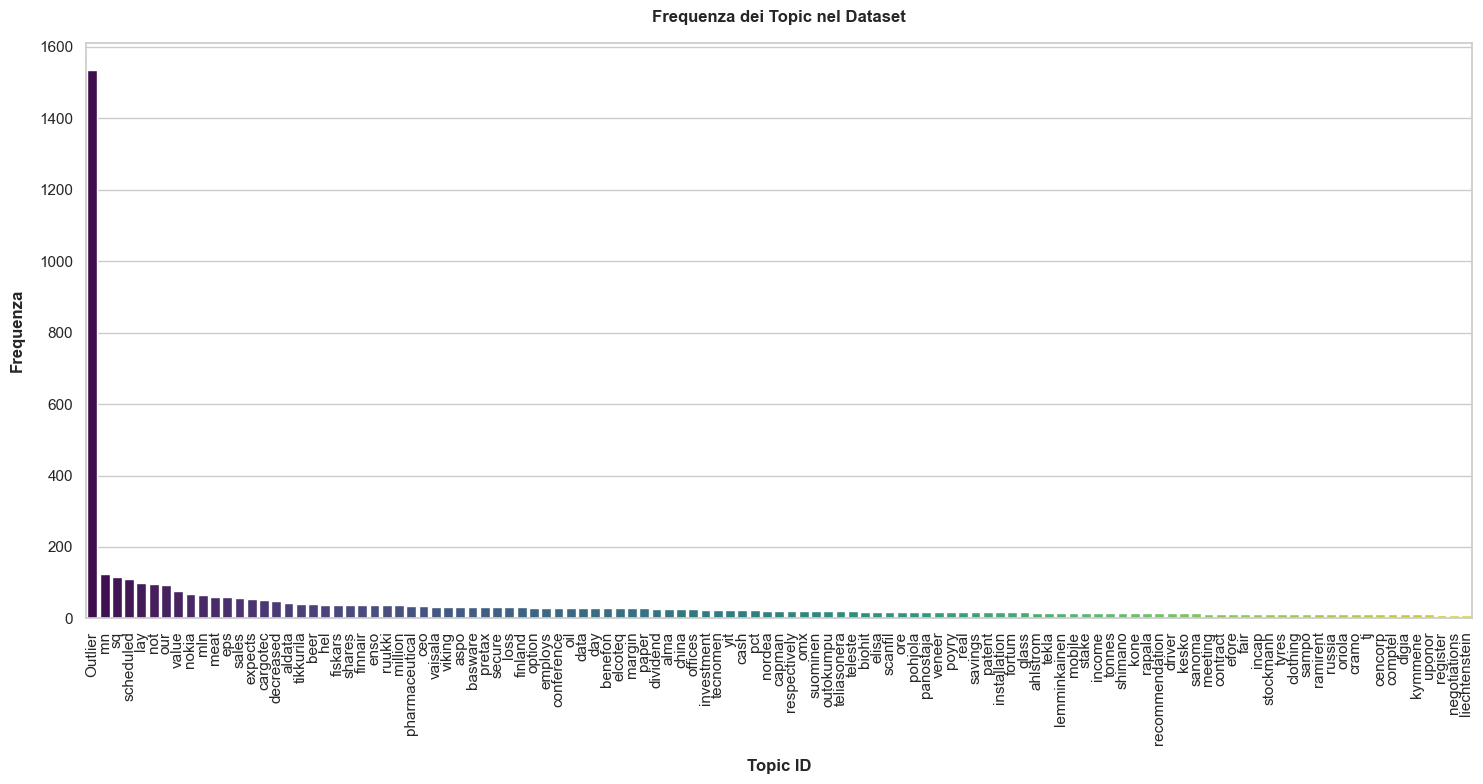

In [6]:
# Conta le occorrenze di ogni topic, ordinate in modo decrescente
topic_counts = df['topic_name'].value_counts().sort_values(ascending=False)  # ascending=True per barh (dal più piccolo al più grande)

custom_barplot(topic_counts.index, 
               topic_counts.values, 
               "Frequenza dei Topic nel Dataset",
               "Topic ID",
               "Frequenza")

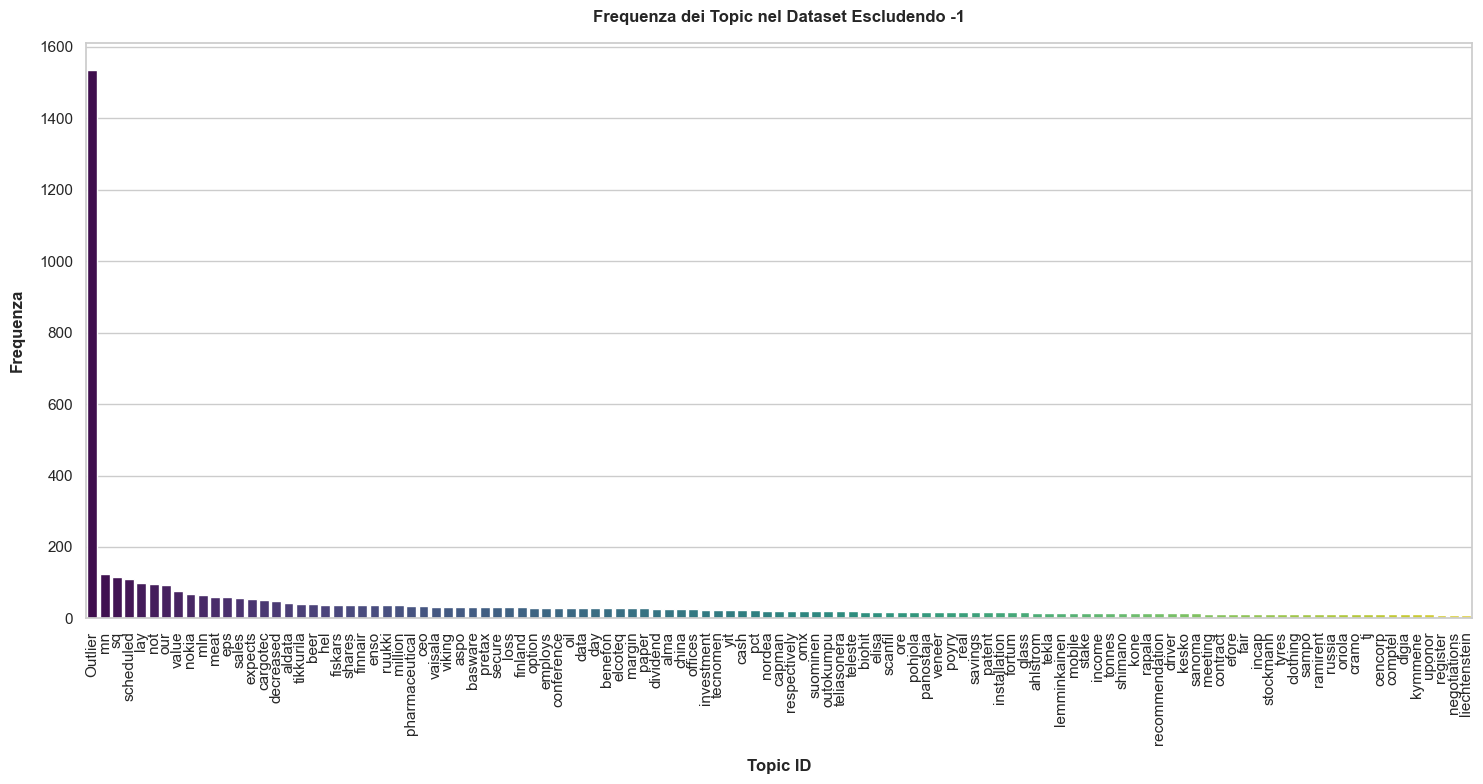

In [7]:
# Conta le occorrenze di ogni topic, ordinate in modo decrescente
df_noutlier = df[ df["topic_name"] != "outlier"]
topic_counts = df_noutlier['topic_name'].value_counts().sort_values(ascending=False)  # ascending=True per barh (dal più piccolo al più grande)

custom_barplot(topic_counts.index, 
               topic_counts.values, 
               "Frequenza dei Topic nel Dataset Escludendo -1",
               "Topic ID",
               "Frequenza")

In [8]:
# Aumenta la lunghezza massima dei valori di stringa mostrati
pd.set_option('display.max_colwidth', None)

df_nokia = df[df["topic_name"] == 'nokia']

print("Esempi di frasi con topic Nokia:")
for phrase in df_nokia["cleaned_text"].head(8):
    print("- " + phrase)

Esempi di frasi con topic Nokia:
- agreement strengthens longterm partnership nokia siemens network
- nokia also noted average selling price handset declined period though mobile phone profit margin rose NUM percent NUM percent yearago quarter
- nokia world largest mobile phone manufacturer china postel china largest mobile phone distributor longstanding partnership continues grow stronger time
- launch new 3g handset nokia aim become winner china 3g market 2g market
- nokian capacitor equipment used raise capacity reliability indian grid
- theodosopoulos said tellabs could value nokia siemens nortel given leading supply status verizon along highgrowth product
- london marketwatch nokia nok said fiveyear service contract run hutchison essar network operation nine location india
- according nordic financial group nordea analyst sami sarkamies make nokia portfolio competitive


In [10]:
outlier_count = (df['topic'] == -1).sum()

print(f"{outlier_count} frasi non sono state assegnate a nessun topic (outlier -1)")
print("\nEsempio di frasi non assegnate a dei topic")

df_outlier = df[df.topic_name == "outlier"]
for phrase in df_outlier["cleaned_text"].head(3):
    print("- " + phrase)

1534 frasi non sono state assegnate a nessun topic (outlier -1)

Esempio di frasi non assegnate a dei topic


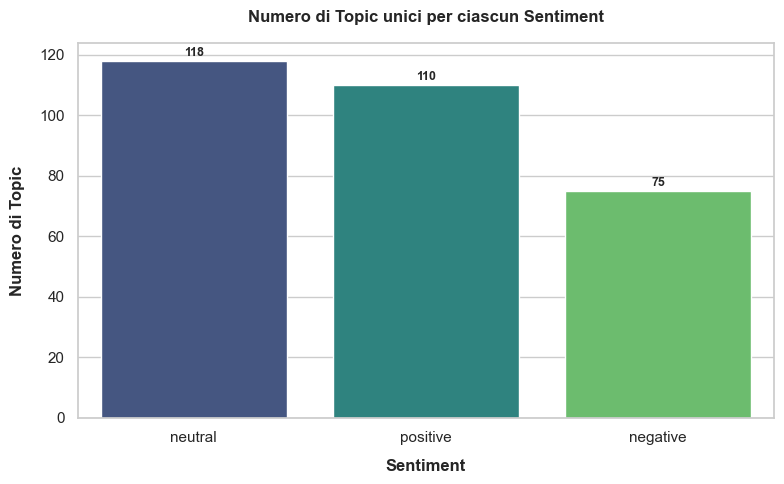

In [11]:
# Conta il numero di topic unici per ciascun sentimento
topics_per_sentiment = df.groupby('label')['topic'].nunique().sort_values(ascending=False)


plt.figure(figsize=(8, 5))
topics_per_sentiment_df = topics_per_sentiment.reset_index(name='num_topics')

plot = sns.barplot(x='label', y='num_topics', data=topics_per_sentiment_df, palette='viridis')
for i, count in enumerate(topics_per_sentiment.values):
    plot.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title("Numero di Topic unici per ciascun Sentiment", fontweight="bold", pad=15)
plt.ylabel("Numero di Topic", fontweight="bold", labelpad=10)
plt.xlabel("Sentiment", fontweight="bold", labelpad=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


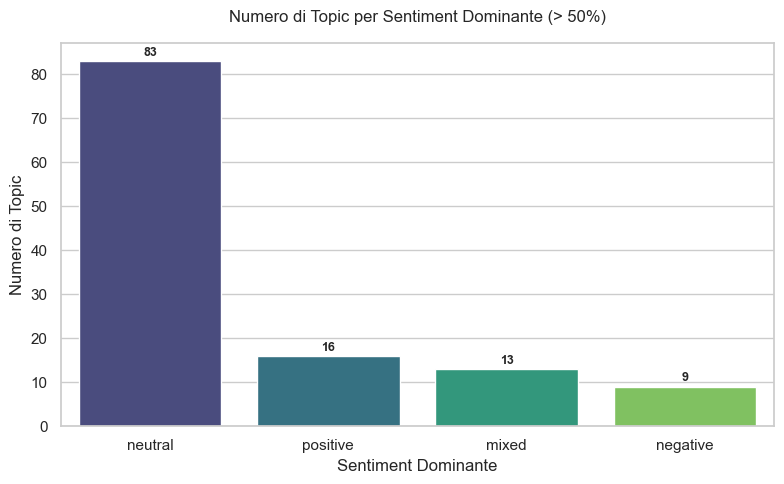

In [12]:
# 🔢 Step 1: Crosstab con frequenza sentimenti per topic
topic_sentiment_ct = pd.crosstab(df['topic'], df['label'])

# 🔁 Step 2: Calcola la quota (%) di ogni sentimento per topic
topic_sentiment_pct = topic_sentiment_ct.div(topic_sentiment_ct.sum(axis=1), axis=0)

# 🎯 Step 3: Determina il sentimento dominante solo se ha più del 50%
def get_dominant_sentiment(row):
    max_sentiment = row.idxmax()
    if row[max_sentiment] > 0.5:
        return max_sentiment
    else:
        return 'mixed'

topic_sentiment_pct['dominant_sentiment'] = topic_sentiment_pct.apply(get_dominant_sentiment, axis=1)

# Step 4: Conta quanti topic hanno dominante positivo, negativo, etc.
dominant_counts = topic_sentiment_pct['dominant_sentiment'].value_counts()

# Converto in DataFrame per usarlo con seaborn
dominant_df = dominant_counts.reset_index()
dominant_df.columns = ['sentiment', 'count']

# Step 5: Visualizza con Seaborn
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='sentiment', y='count', data=dominant_df, palette='viridis')

# Aggiungi etichette sopra le barre
for i, row in dominant_df.iterrows():
    ax.text(i, row['count'] + 0.5, str(row['count']),
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title("Numero di Topic per Sentiment Dominante (> 50%)", pad=15)
plt.xlabel("Sentiment Dominante")
plt.ylabel("Numero di Topic")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Analisi Topic: Outlier -1

### Differenza Lunghezza testo tra Testo Outliere e Non

In [13]:
# Calcolo lunghezza in parole
df['text_len'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['text_len_unique'] = df['cleaned_text'].apply(lambda x: len(set(x.split())))

In [14]:
df[["cleaned_text", "text_len","text_len_unique"]].head(3)

,cleaned_text,text_len,text_len_unique
0,according gran company plan move production russia although company growing,10,9
1,technopolis plan develop stage area less NUM square meter order host company working computer technology telecommunication statement said,18,18
2,international electronic industry company elcoteq laid ten employee tallinn facility contrary earlier layoff company contracted rank office worker daily postimees reported,21,20


In [15]:
df_outlier = df[ df["topic"] == -1 ]
df_noutlier = df[ df["topic"] != -1 ]

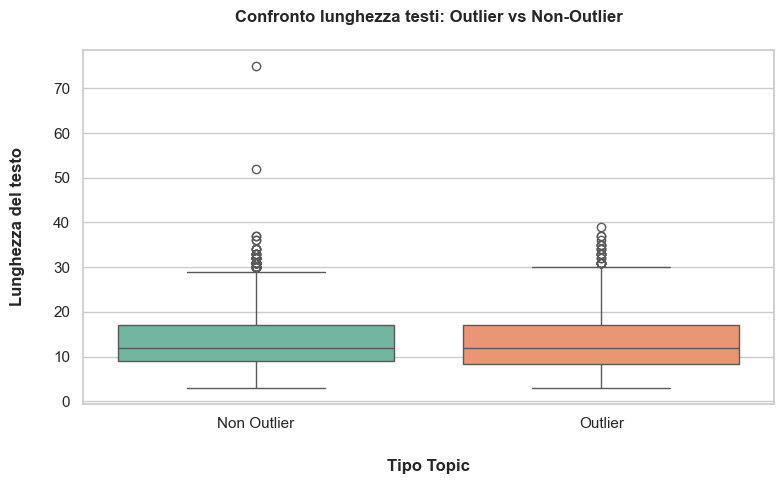

Lunghezza media testi outlier: 13.49
Lunghezza media testi non outlier: 13.46


In [16]:
# Confronto tra outlier e non-outlier
df['is_outlier'] = df['topic'] == -1

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='is_outlier', y='text_len', palette='Set2')
plt.title("Confronto lunghezza testi: Outlier vs Non-Outlier", pad=20, fontweight="bold")
plt.xlabel("Tipo Topic", labelpad=20, fontweight="bold")
plt.ylabel("Lunghezza del testo", labelpad=20, fontweight="bold")
plt.xticks([0,1], ['Non Outlier', 'Outlier'])
plt.tight_layout()
plt.show()

print(f"Lunghezza media testi outlier: {df_outlier.text_len.mean():.2f}")
print(f"Lunghezza media testi non outlier: {df_noutlier.text_len.mean():.2f}")

## Differenza Parole uniche per frase Outlier e Non

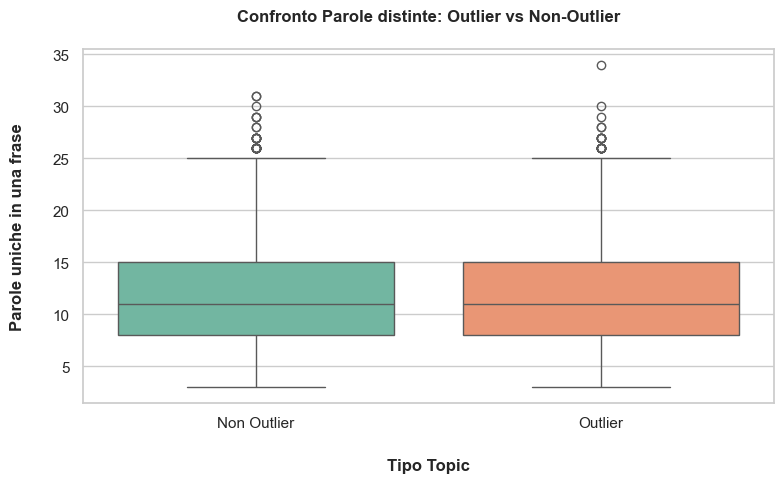

Media parole distinti per frasi outlier: 12.14
Media parole distinti per frasi non outlier: 11.76


In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='is_outlier', y='text_len_unique', palette='Set2')
plt.title("Confronto Parole distinte: Outlier vs Non-Outlier", pad=20, fontweight="bold")
plt.xlabel("Tipo Topic", labelpad=20, fontweight="bold")
plt.ylabel("Parole uniche in una frase", labelpad=20, fontweight="bold")
plt.xticks([0,1], ['Non Outlier', 'Outlier'])
plt.tight_layout()
plt.show()

print(f"Media parole distinti per frasi outlier: {df_outlier.text_len_unique.mean():.2f}")
print(f"Media parole distinti per frasi non outlier: {df_noutlier.text_len_unique.mean():.2f}")

## Top N parole più frequenti tra Topic Outlier e Non Outlier

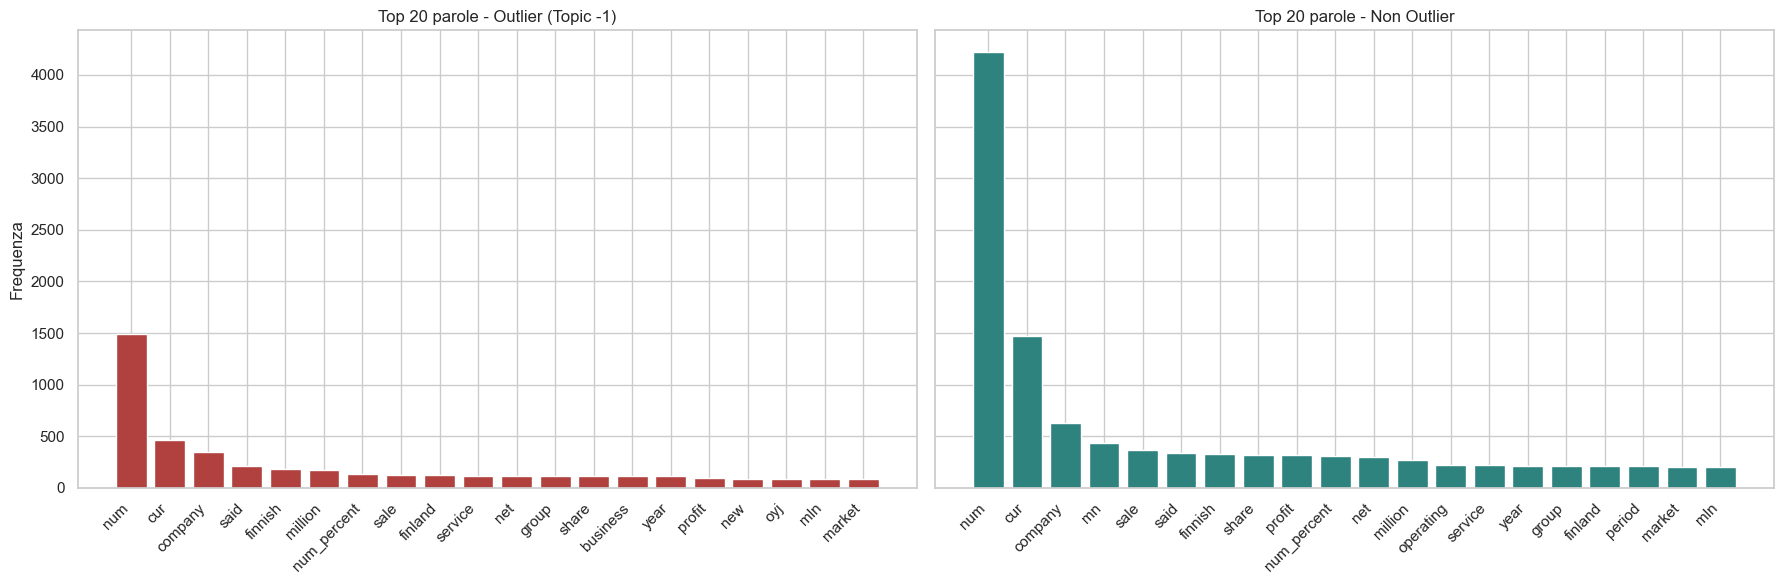

Outlier         Freq   | Non-Outlier     Freq  
--------------------------------------------------
num             1489   | num             4220  
cur             461    | cur             1468  
company         346    | company         625   
said            209    | mn              438   
finnish         182    | sale            371   
million         173    | said            335   
num_percent     134    | finnish         330   
sale            130    | share           322   
finland         127    | profit          320   
service         117    | num_percent     305   
net             116    | net             296   
group           115    | million         268   
share           113    | operating       227   
business        113    | service         222   
year            112    | year            212   
profit          93     | group           212   
new             91     | finland         209   
oyj             91     | period          208   
mln             87     | market      

In [19]:
sns.set(style="whitegrid")  # stile seaborn
warnings.filterwarnings("ignore")

# Parametri
N = 20  # Numero parole da visualizzare

# Split dei testi
outlier_texts = df[df['topic'] == -1]['cleaned_text']
non_outlier_texts = df[df['topic'] != -1]['cleaned_text']

# Funzione per calcolare le top N parole
def get_top_words(text_series, top_n=20):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_series)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_n]

# Ottieni top parole
top_outlier = get_top_words(outlier_texts, top_n=N)
top_non_outlier = get_top_words(non_outlier_texts, top_n=N)

# Estrai parole e frequenze
words_out, counts_out = zip(*top_outlier)
words_non, counts_non = zip(*top_non_outlier)

# 🎨 Visualizzazione affiancata
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

axes[0].bar(words_out, counts_out, color="#b0413e")
axes[0].set_title(f"Top {N} parole - Outlier (Topic -1)")
axes[0].set_xticklabels(words_out, rotation=45, ha='right')
axes[0].set_ylabel("Frequenza")

axes[1].bar(words_non, counts_non, color="#2f837f")
axes[1].set_title(f"Top {N} parole - Non Outlier")
axes[1].set_xticklabels(words_non, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"{'Outlier':<15} {'Freq':<6} | {'Non-Outlier':<15} {'Freq':<6}")
print("-" * 50)
for (w_out, c_out), (w_non, c_non) in zip(zip(words_out, counts_out), zip(words_non, counts_non)):
    print(f"{w_out:<15} {c_out:<6} | {w_non:<15} {c_non:<6}")



Come si nota dai grafici e dalla tabella, ci sono **sovrapposizioni evidenti tra i due topic**, infatti, parole come : num, cur, company, sale, said, finnish, finland, share, profit, net **compaiono in entrambe le liste e in posizioni simili.**

Questo ci dice che le parole da sole non bastano a spiegare perché certi testi siano stati marcati come outlier. Bisogna fare delle analisi più approfondite

## Analisi Spaziale degli embedding

In [20]:
# Preprocessing testi
documents = df['cleaned_text'].astype(str).tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(documents, show_progress_bar=True)


Batches: 100%|██████████| 151/151 [00:44<00:00,  3.41it/s]


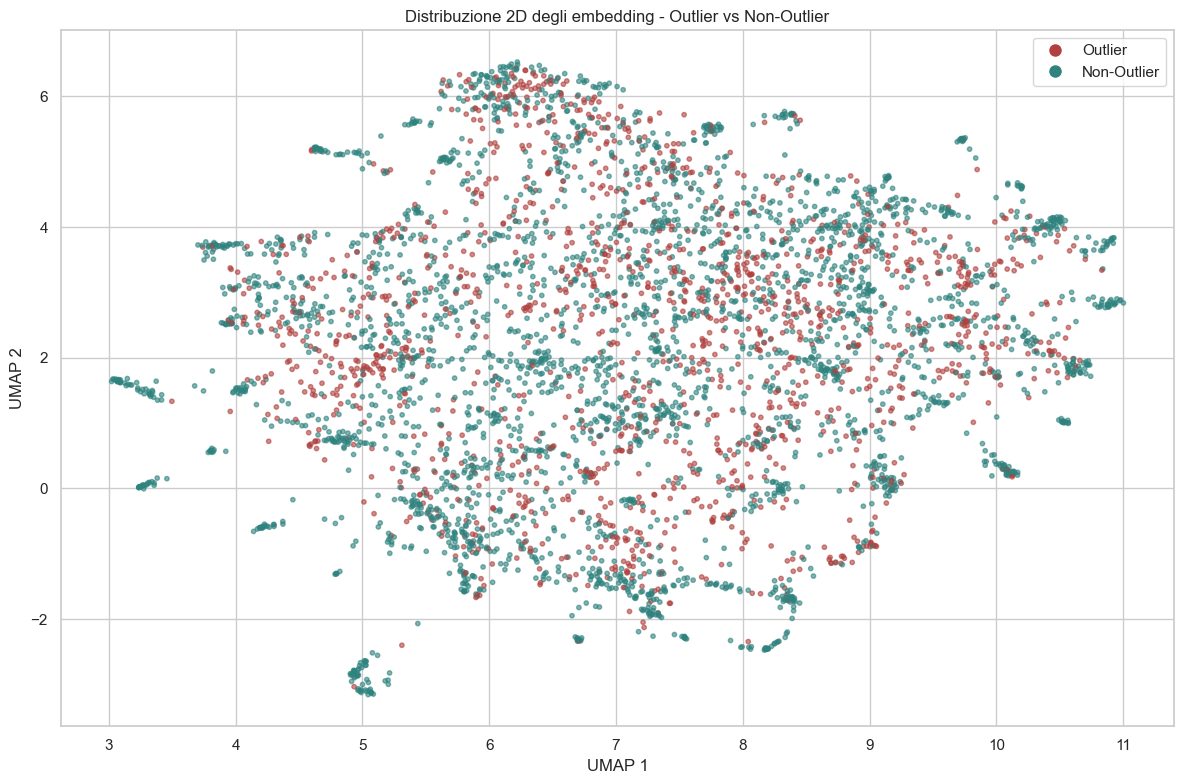

In [21]:
# Riduzione dimensionale a 2D
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)

# Crea un DataFrame con le coordinate UMAP e info sul topic
df_embed = pd.DataFrame(embeddings_2d, columns=["x", "y"])
df_embed["topic"] = df["topic"].values
df_embed["Outlier"] = df_embed["topic"] == -1

plt.figure(figsize=(12, 8))
colors = df_embed["Outlier"].map({True: "#b0413e", False: "#2f837f"})

plt.scatter(df_embed["x"], df_embed["y"], c=colors, alpha=0.6, s=10)
plt.title("Distribuzione 2D degli embedding - Outlier vs Non-Outlier")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='#b0413e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Non-Outlier', markerfacecolor='#2f837f', markersize=10)
])
plt.tight_layout()
plt.show()

Dal grafico si evince che nella maggior parte dei casi, i puntini rossi (embedding cosinderati outlier) sono semanticamente più isolati e/o sparsi ripsetto agli embedding in verde. Nello stesso tempo, esistono anche gruppetti di embedding rossi vicini tra loro, ma sono troppo pochi per crere un cluster di topic.

In conclusione, l'assegnazione di una frase al topic Outlier / Non Outlier non è una questione di lunghezza o lessico singolo, ma di posizione nello spazio degli embedding.

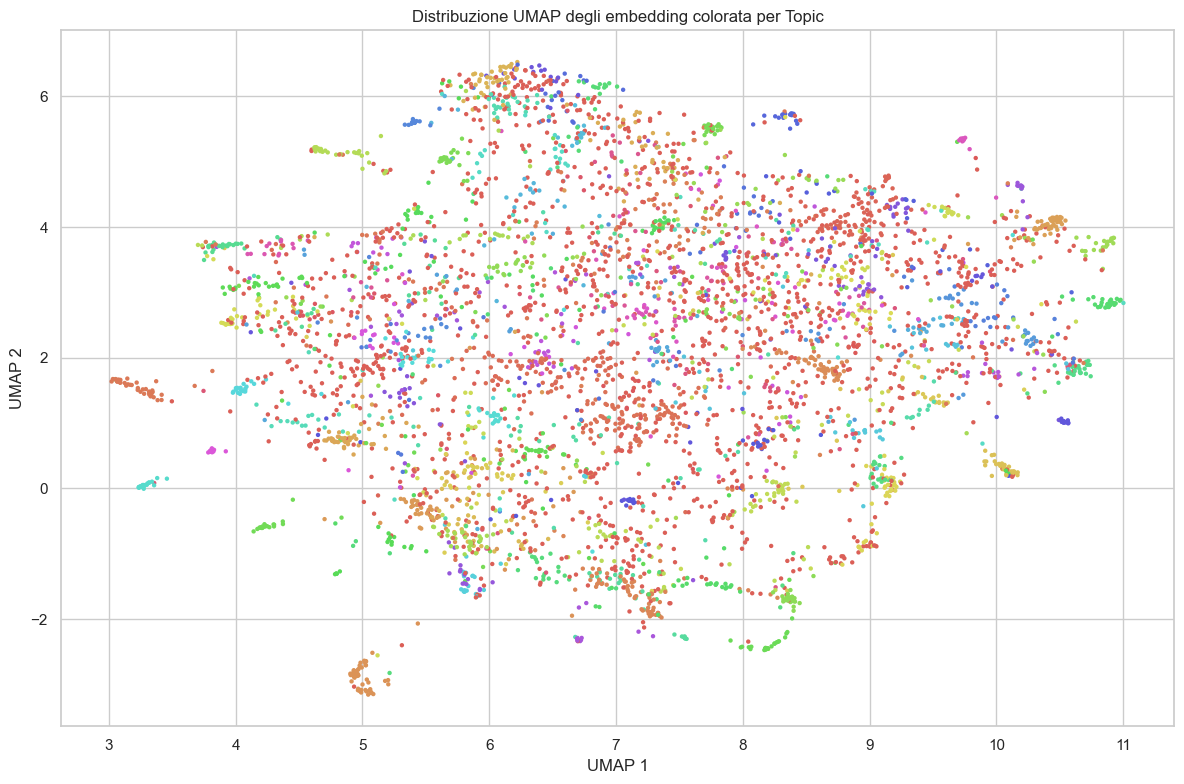

In [23]:
# Riduzione dimensionale
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)

# DataFrame con coordinate e topic
df_umap = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_umap['topic'] = df['topic'].values

# Ordina topic per chiarezza visiva
topic_order = df_umap['topic'].value_counts().index
palette = sns.color_palette("hls", len(topic_order))

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_umap,
    x="x", y="y",
    hue="topic",
    palette=palette,
    s=10,
    linewidth=0
)

plt.title("Distribuzione UMAP degli embedding colorata per Topic")
plt.legend([], [], frameon=False)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

- I colori formano regioni distinte. Questo suggerisce che BertTopic ha segmentato in maniera sensata le frasi nello spazio semantico.
- infatti, alcuni topic si vedono ben compatti (nei margini o negli angoli), che rappresentano un alta coerenza interna - topic forti.
- In alcune regioni (soprattutto al centro), ci sono regioni molto vicine o che si fondono, questo capita quando i topic sono simili e quindi si sovrappongono semnaticamente. In una fase successiva, si potrebbe pensare anche di unire questi topic in modo da avere meno topic, con più frasi.

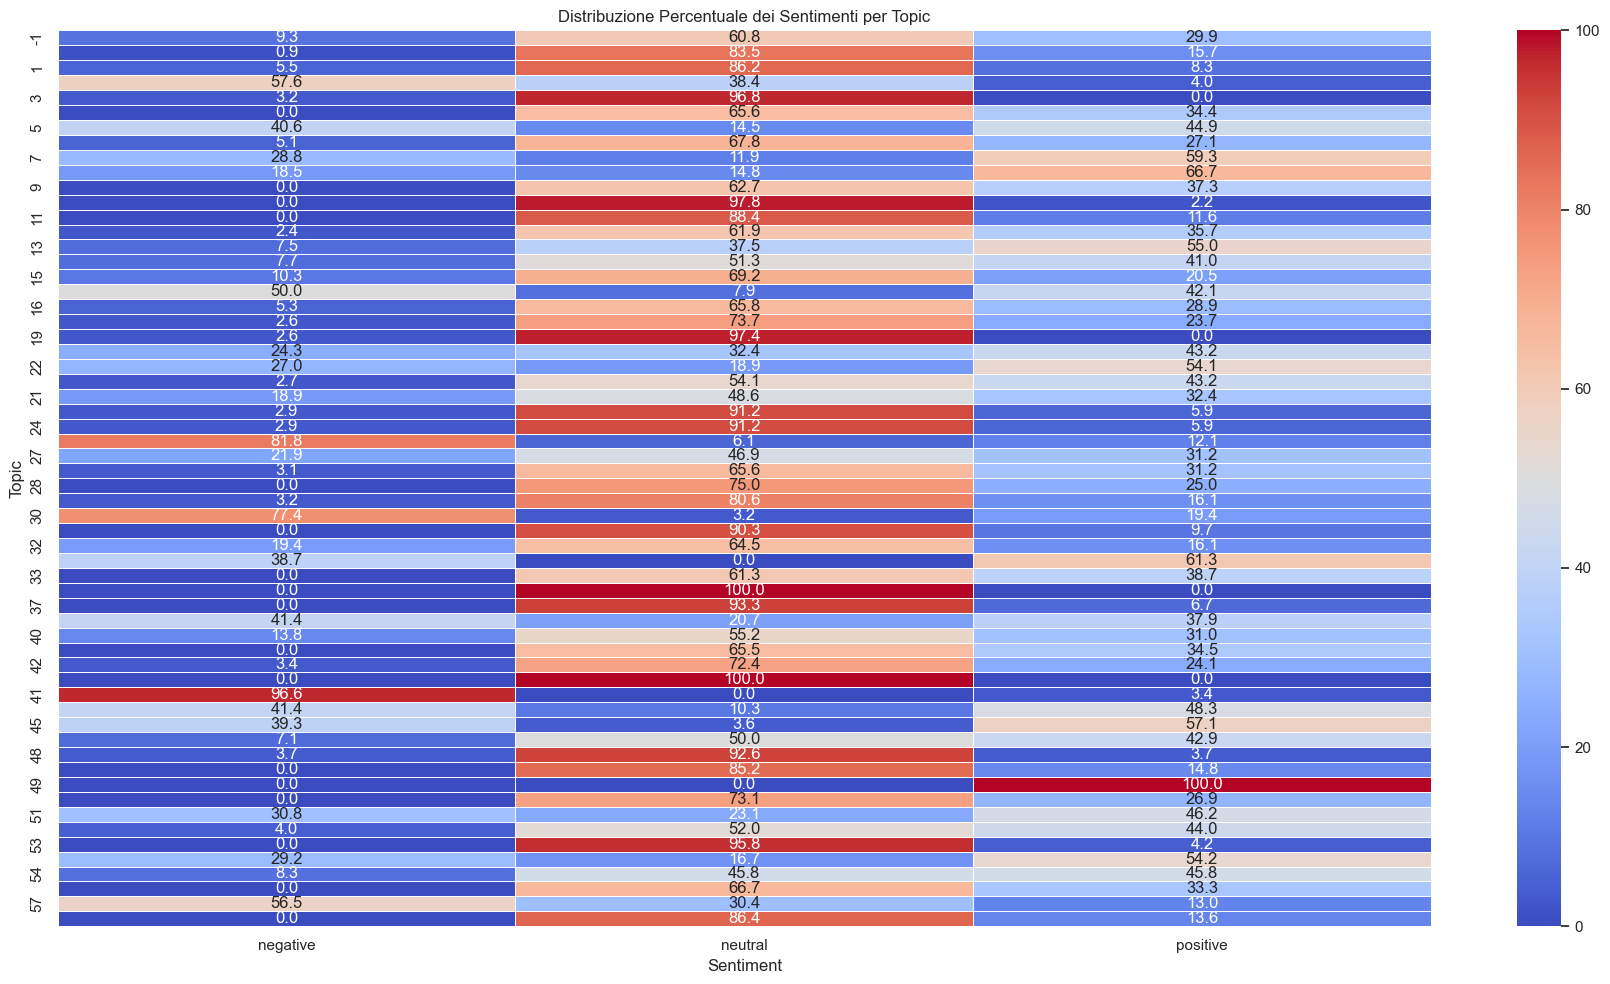

In [24]:
# Calcola la tabella di contingenza normalizzata per riga (percentuale per topic)
topic_sentiment_dist = pd.crosstab(df['topic'], df['label'], normalize='index') * 100

# Ordina i topic per frequenza decrescente (opzionale)
topic_order = df['topic'].value_counts().head(60).index
topic_sentiment_dist = topic_sentiment_dist.loc[topic_order]

# Heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(topic_sentiment_dist, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5)

plt.title("Distribuzione Percentuale dei Sentimenti per Topic")
plt.xlabel("Sentiment")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


In [26]:
# Calcola distribuzione percentuale dei sentiment per topic
topic_sentiment_pct = pd.crosstab(df['topic'], df['label'], normalize='index') * 100 

# Trova il sentiment dominante e la percentuale per ciascun topic
dominant_sentiment = topic_sentiment_pct.idxmax(axis=1)
dominant_percent = topic_sentiment_pct.max(axis=1)

# Unisci in un DataFrame
polarized_topics = pd.DataFrame({
    'Dominant_Sentiment': dominant_sentiment,
    'Dominant_Percent': dominant_percent.round(2),
    'Num_Samples': df['topic'].value_counts()
})

# Filtro: solo topic con un sentiment ≥80%
polarized_topics = polarized_topics[polarized_topics['Dominant_Percent'] >= 80]

# Ordina per polarizzazione più alta
polarized_topics = polarized_topics.sort_values(by='Dominant_Percent', ascending=False)

polarized_topics.head(20)

,Dominant_Sentiment,Dominant_Percent,Num_Samples
topic,,,
36,neutral,100.00,30
105,neutral,100.00,13
77,neutral,100.00,17
49,positive,100.00,26
39,neutral,100.00,29
10,neutral,97.78,45
19,neutral,97.37,38
3,neutral,96.84,95
41,negative,96.55,29


In [27]:
# Trova la riga con la massima dominanza per ciascun sentimento
top_neutral_row = polarized_topics[polarized_topics['Dominant_Sentiment'] == 'neutral'].sort_values(by='Dominant_Percent', ascending=False).iloc[0]
top_positive_row = polarized_topics[polarized_topics['Dominant_Sentiment'] == 'positive'].sort_values(by='Dominant_Percent', ascending=False).iloc[0]
top_negative_row = polarized_topics[polarized_topics['Dominant_Sentiment'] == 'negative'].sort_values(by='Dominant_Percent', ascending=False).iloc[0]

# Estrai topic ID (che è l'indice) e percentuale
top_topic_neutral = top_neutral_row.name
dominance_neutral = top_neutral_row['Dominant_Percent']

top_topic_positive = top_positive_row.name
dominance_positive = top_positive_row['Dominant_Percent']

top_topic_negative = top_negative_row.name
dominance_negative = top_negative_row['Dominant_Percent']

# Stampa il risultato
print(f"Top topic NEUTRAL: {top_topic_neutral} ({dominance_neutral:.2f}%)")
print(f"Top topic POSITIVE: {top_topic_positive} ({dominance_positive:.2f}%)")
print(f"Top topic NEGATIVE: {top_topic_negative} ({dominance_negative:.2f}%)")


Top topic NEUTRAL: 36 (100.00%)
Top topic POSITIVE: 49 (100.00%)
Top topic NEGATIVE: 41 (96.55%)


## Confronto Tra Topic Neutrale e Negativo

In [28]:
def topic_word_cloud(df_topic, topic):
    all_text = ' '.join(df_topic['cleaned_text'])
    wordcloud = WordCloud(width=2000, height=1200, max_words=100, max_font_size=150, background_color='white').generate(all_text)

    plt.figure(figsize=(18, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud Topic {str(topic)}", pad=10, weight= 'bold')
    plt.axis('off')
    plt.show()
    


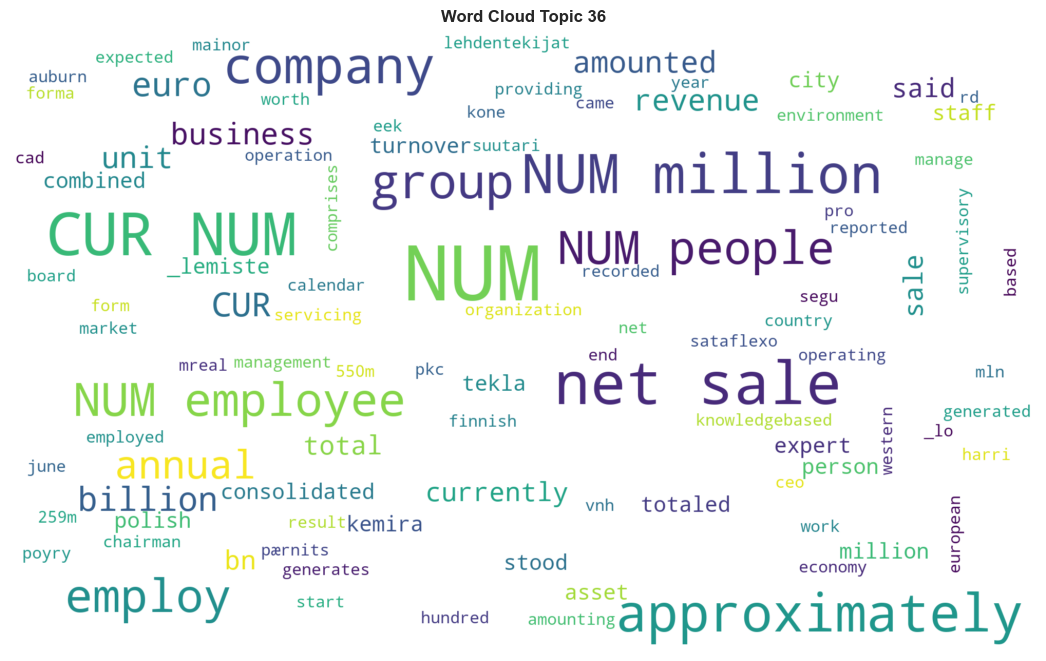

In [29]:
df_topic_neutral = df[ df["topic"] == top_topic_neutral]
topic_word_cloud(df_topic_neutral, top_topic_neutral)


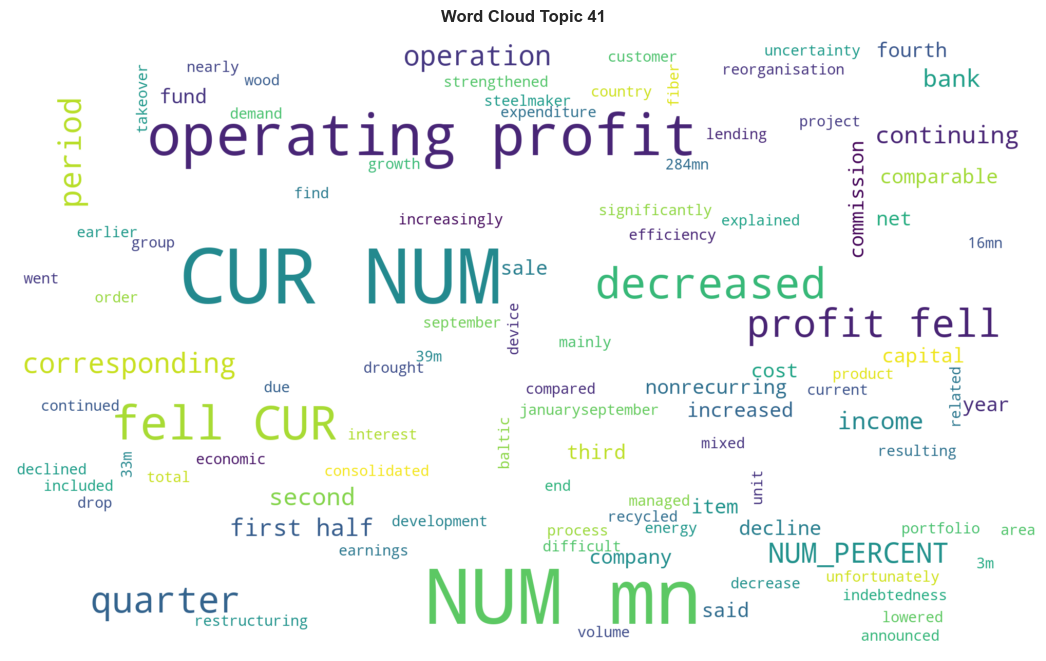

In [33]:
df_topic_negative = df[ df["topic"] == top_topic_negative]
topic_word_cloud(df_topic_negative, top_topic_negative)

In [34]:
def top_n_words_topic(n, df_topic, topic, sentiment):
    # Conta la frequenza delle parole nel topic
    all_words = ' '.join(df_topic['cleaned_text'])
    word_counts = Counter(all_words.split())

    # Le 30 parole più frequenti
    common_words = word_counts.most_common(n)

    # Dividi le parole e le loro frequenze
    words_topic, counts = zip(*common_words)

    # Creiamo il grafico a barre
    plt.figure(figsize=(18, 10))
    sns.barplot(x=words_topic, y=counts, palette='viridis')
    plt.title(f"Top {str(n)} Parole Più Frequenti nel Topic {str((topic))} ({sentiment})")
    plt.xlabel("Parola")
    plt.ylabel("Frequenza")
    plt.xticks(rotation=45)
    plt.show()

    return set(words_topic)

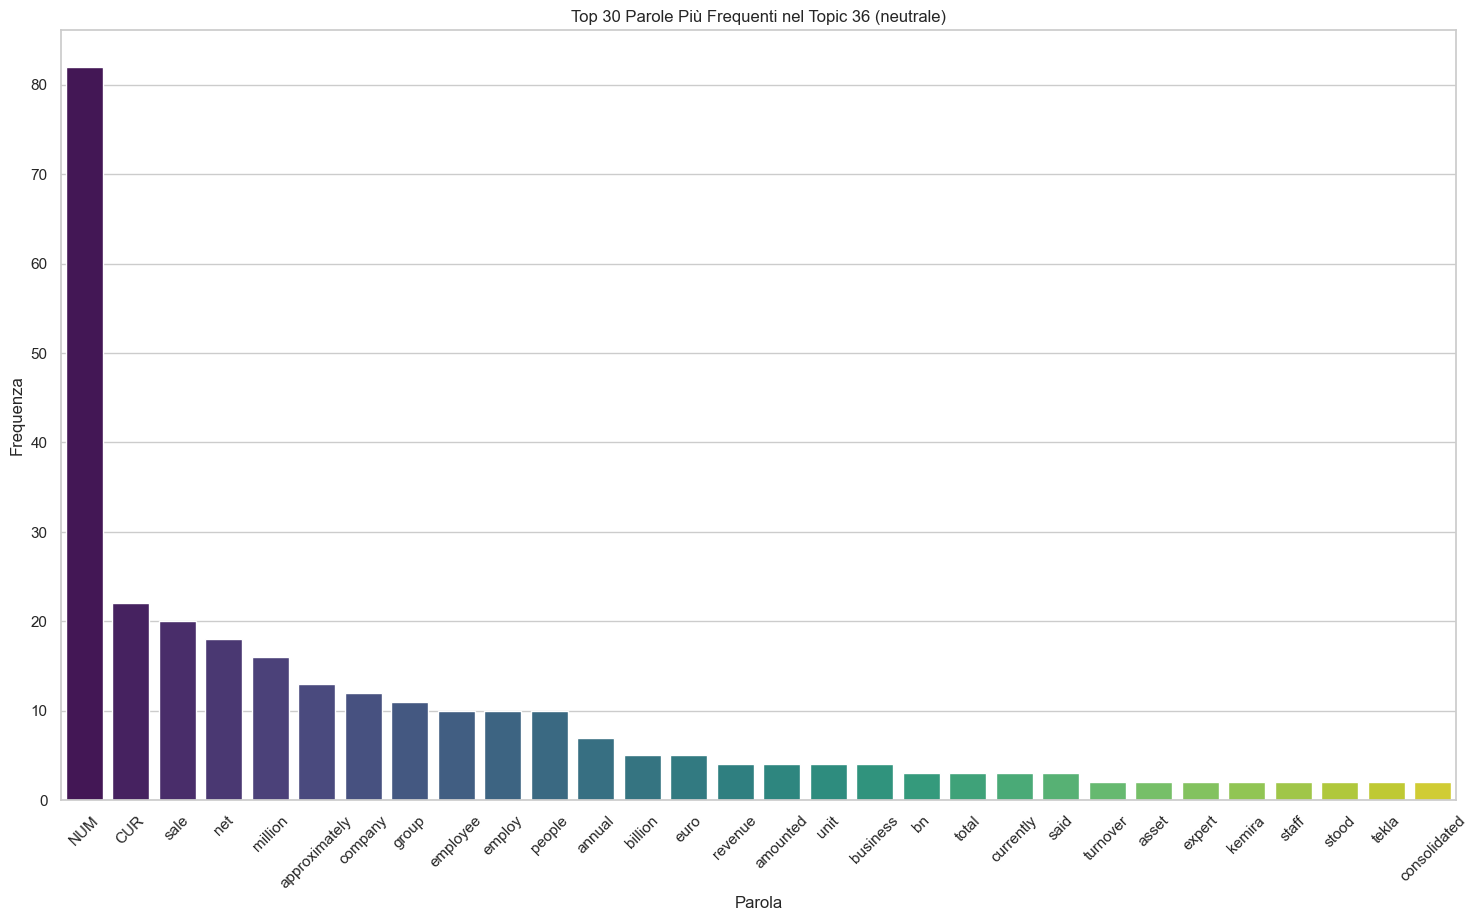

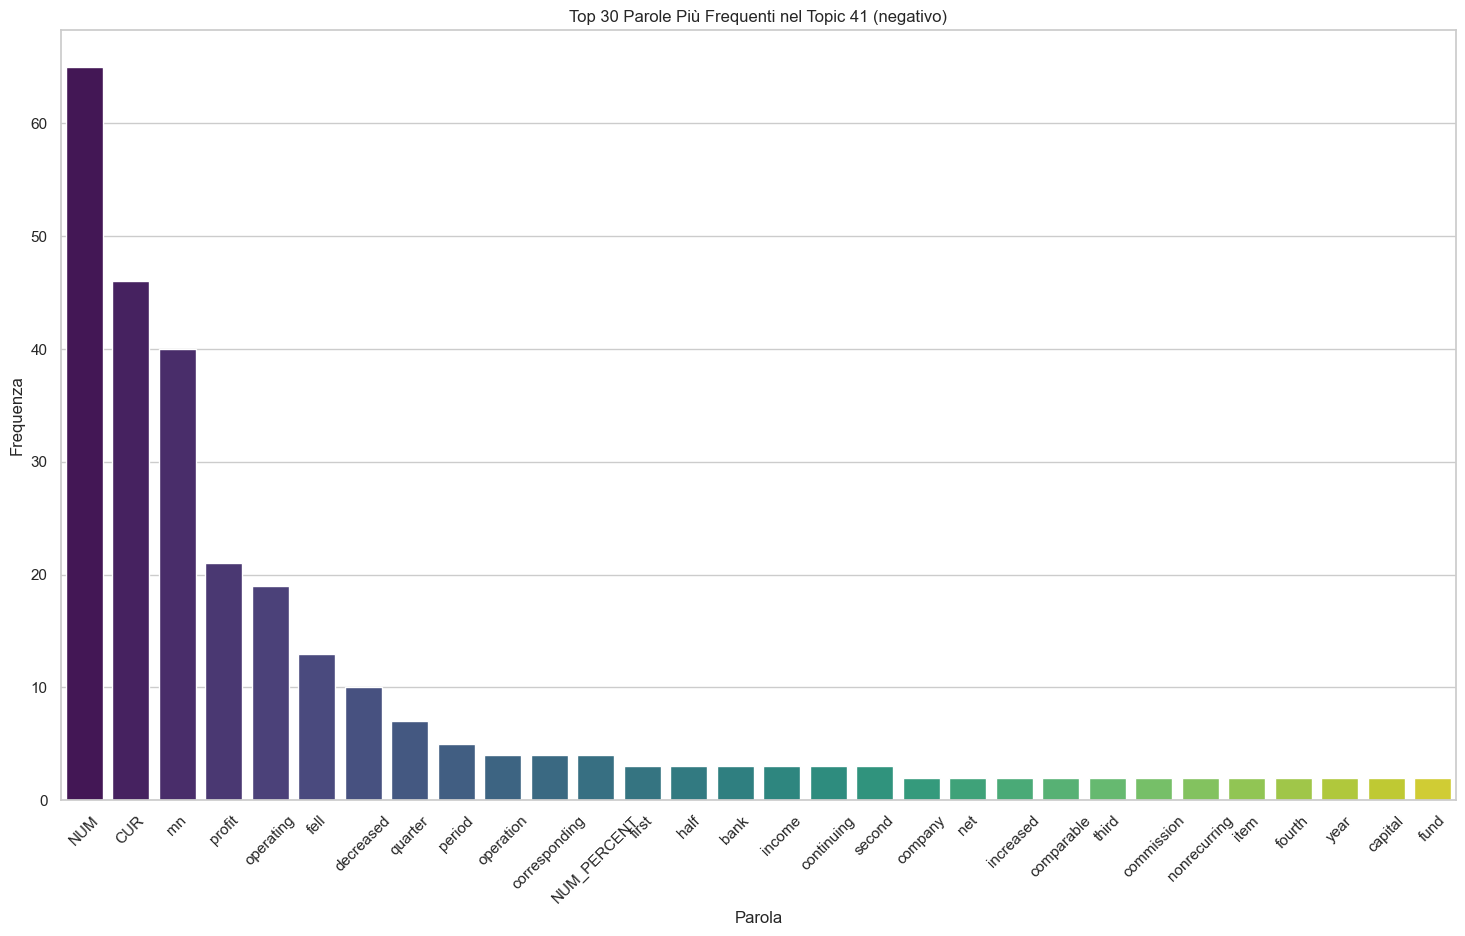

In [35]:
words_topic_neutral = top_n_words_topic(30, df_topic_neutral, top_topic_neutral, "neutrale")
words_topic_negative = top_n_words_topic(30, df_topic_negative, top_topic_negative, "negativo")

In [36]:
common_words = set(words_topic_negative) & set(words_topic_neutral)
print(f"Parole in comune tra topic {top_topic_negative} (negativo) e topic {top_topic_neutral} (neutrale): \n{len(common_words)} -> {', '.join(common_words)}")


Parole in comune tra topic 41 (negativo) e topic 36 (neutrale): 
4 -> NUM, CUR, company, net


## Confronto tra Topic Negativo e Positivo

In [37]:
df_topic_positive = df[ df["topic"] ==  top_topic_positive]

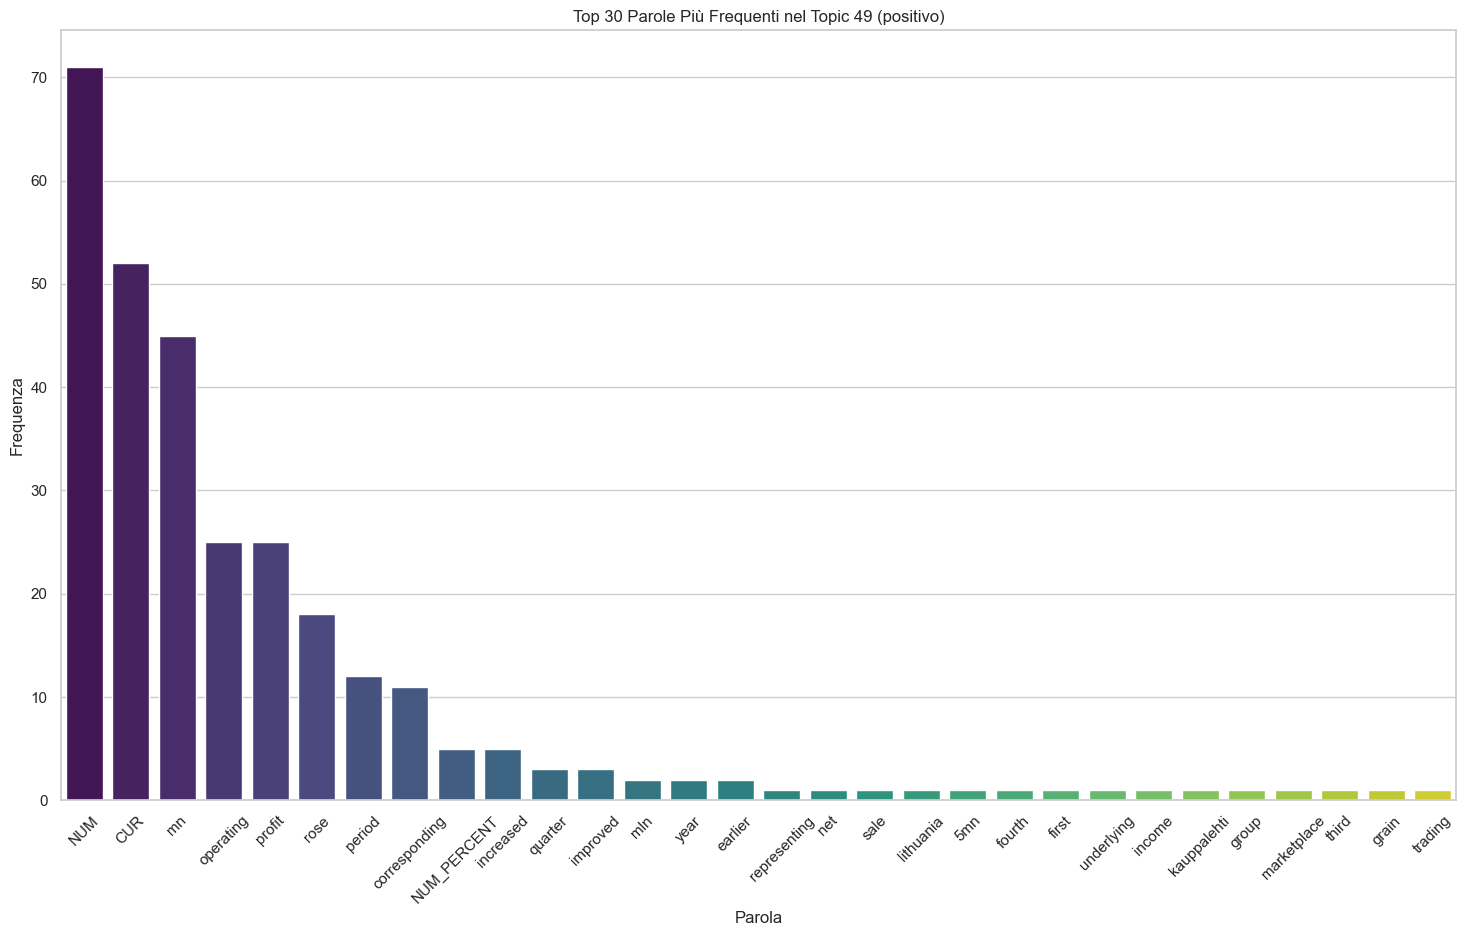

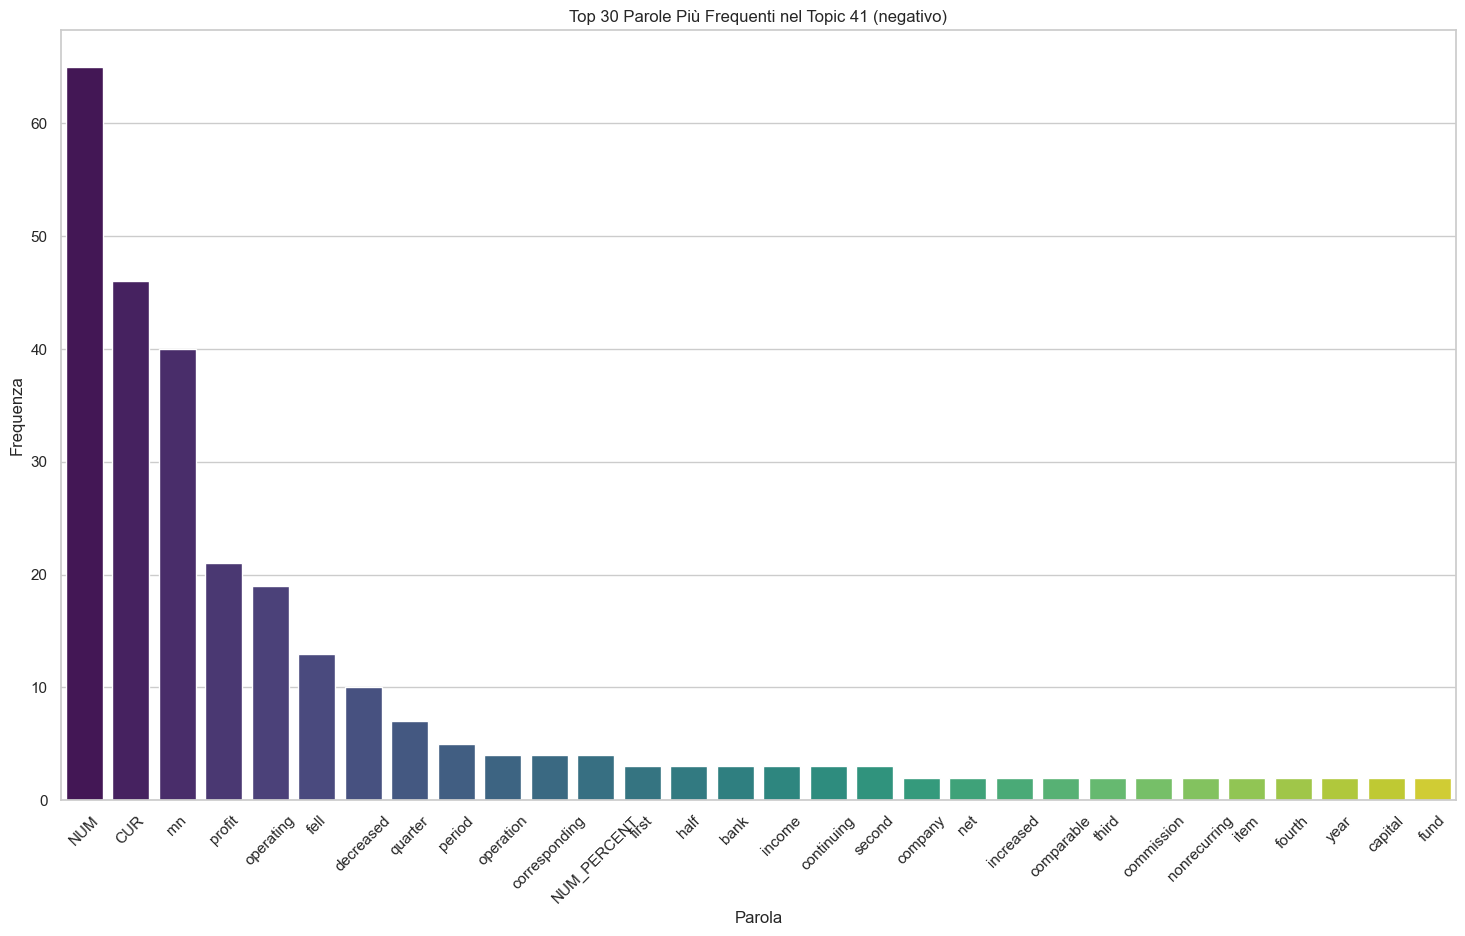

In [38]:
words_topic_positive = top_n_words_topic(30, df_topic_positive, top_topic_positive, "positivo")
words_topic_negative = top_n_words_topic(30, df_topic_negative, top_topic_negative, "negativo")

In [39]:
common_words = set(words_topic_negative) & set(words_topic_positive)
print(f"Parole in comune tra topic {top_topic_negative} (negativo) e topic {top_topic_positive} (positivo): \n{len(common_words)} -> {', '.join(common_words)}")

Parole in comune tra topic 41 (negativo) e topic 49 (positivo): 
16 -> quarter, fourth, third, net, period, profit, first, increased, corresponding, CUR, NUM_PERCENT, income, NUM, mn, year, operating


## Confronto Tra Topic Neutrale e Positivo

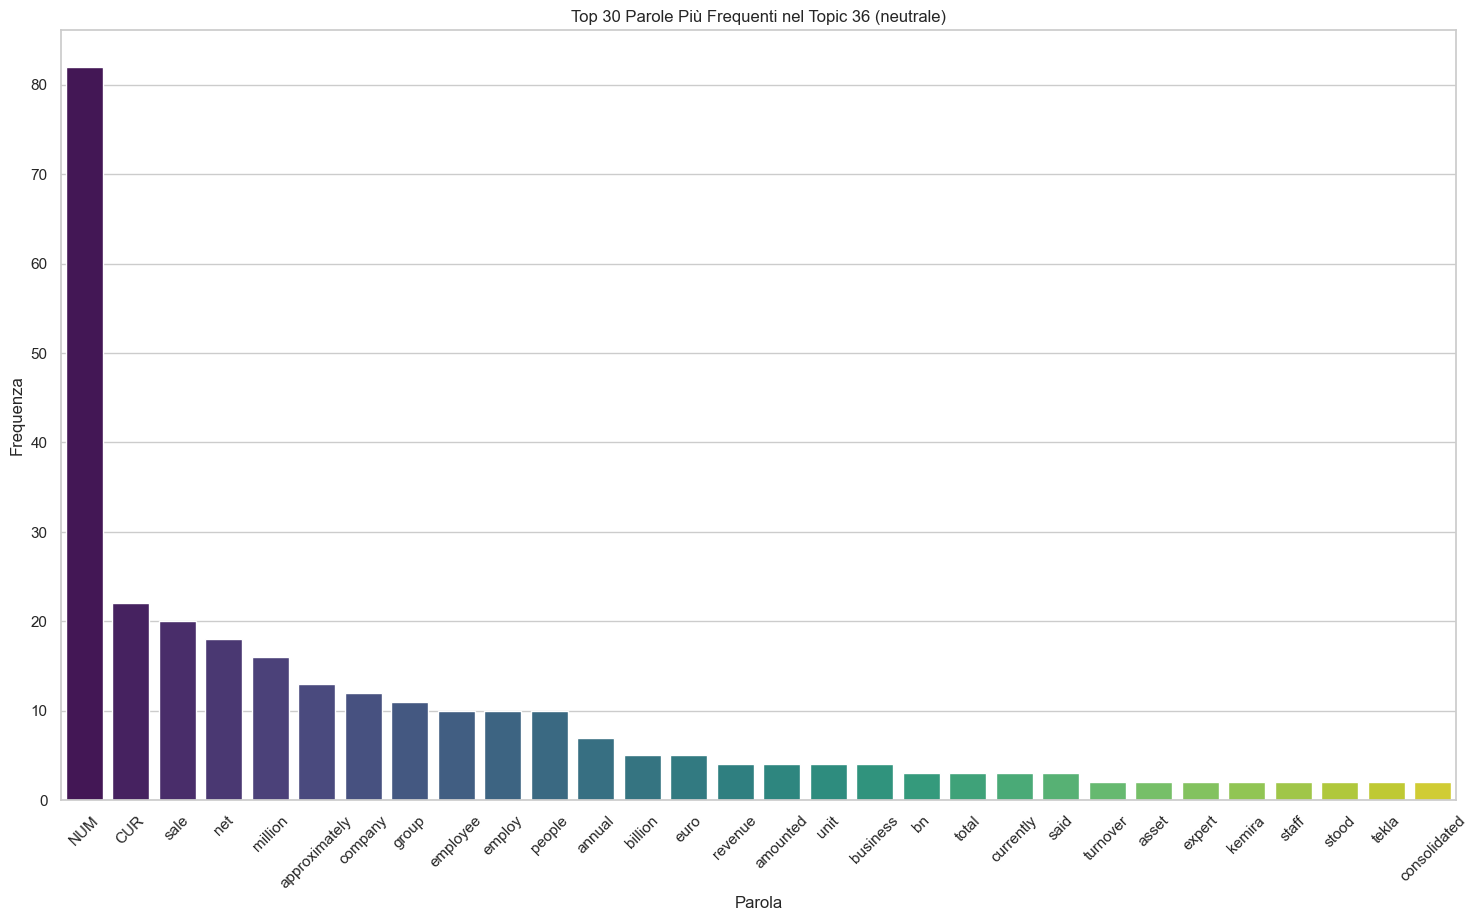

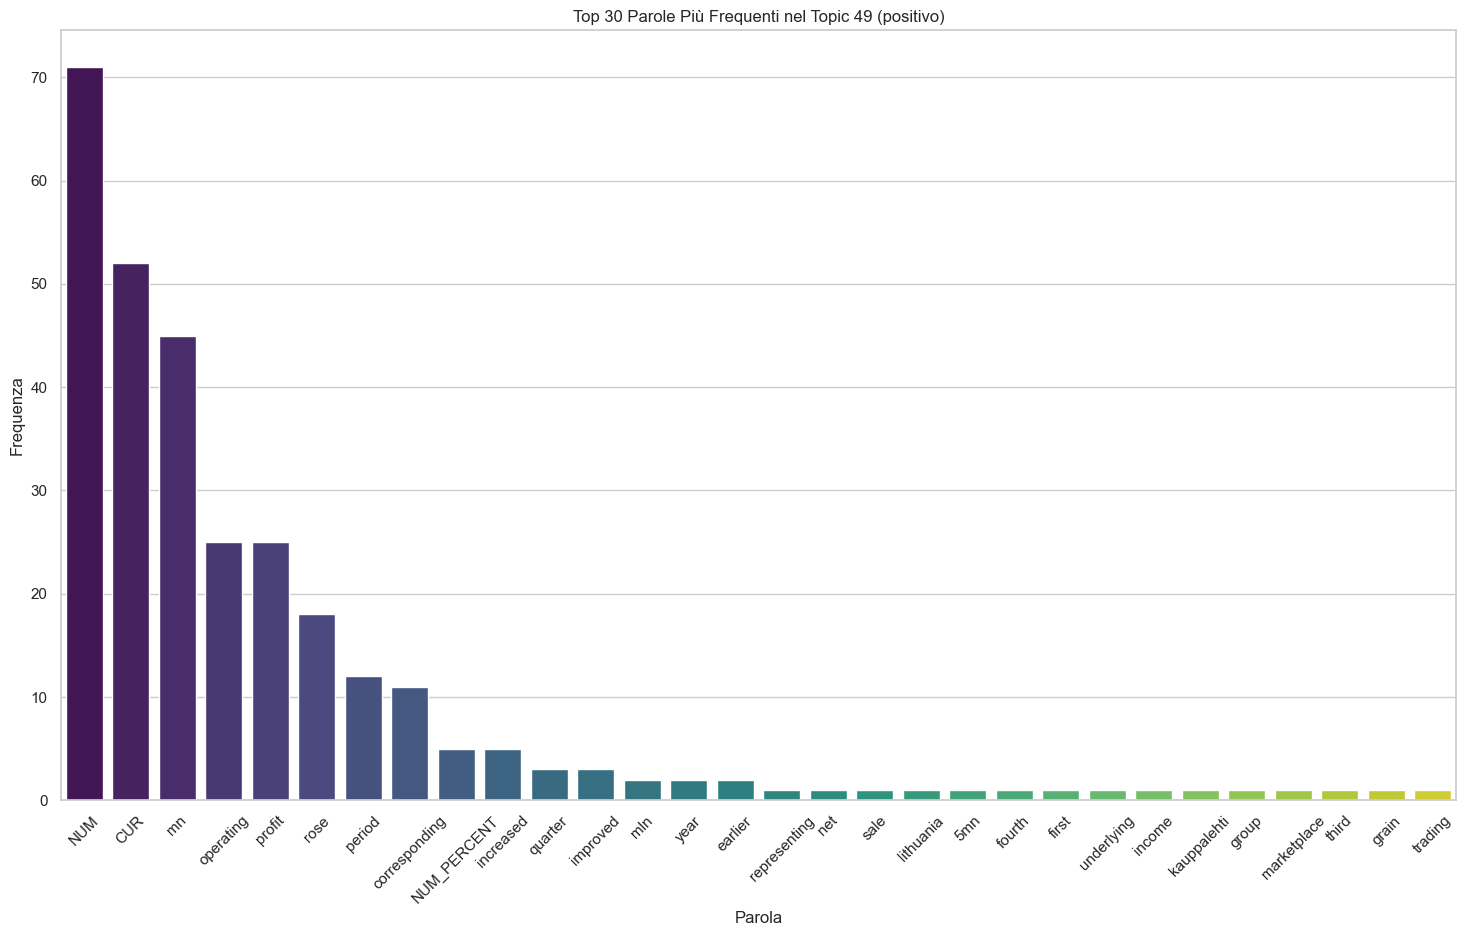

In [40]:
words_topic_neutral = top_n_words_topic(30, df_topic_neutral, top_topic_neutral, "neutrale")
words_topic_positive = top_n_words_topic(30, df_topic_positive, top_topic_positive, "positivo")

In [41]:
common_words = set(words_topic_neutral) & set(words_topic_positive)
print(f"Parole in comune tra topic {top_topic_neutral} (neutrale) e topic {top_topic_positive} (positivo): \n{len(common_words)} -> {', '.join(common_words)}")

Parole in comune tra topic 36 (neutrale) e topic 49 (positivo): 
5 -> net, sale, group, CUR, NUM
